# Lorenz system

Here we consider the Lorenz system. It is a prototypical example of a chaotic attractor in 3D. Below we test the capabilities of the Koopman Kernel Sequencer to captuer the complex, chaotic dynamics.

## Exemplify model training

In [1]:
import torch
import time
from kkseq.koopkernel_sequencer import (
    RBFKernel,
    NystroemKoopKernelSequencer,
    KoopKernelLoss,
)
import matplotlib.pyplot as plt
import numpy as np
from kkseq.data_utils import standardized_context_dataset_from_time_series_list, standardized_batched_context_from_time_series_list, LinearScaler
from kkseq.koopkernel_sequencer_utils import RMSE
from kooplearn.datasets import Lorenz63
from matplotlib.ticker import MultipleLocator
from kkseq.koopkernel_sequencer_utils import (
    eval_one_epoch,
    train_one_epoch,
)

Generate Lorenz63 data.

In [2]:
configs = {
    "train_samples": 10000,
    "valid_samples": 1000,
    "test_samples": 100,
}

raw_data = Lorenz63().sample(
    X0=np.ones(3),
    T=configs["train_samples"]
    + 1000
    + configs["valid_samples"]
    + 1000
    + configs["test_samples"],
)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm
dataset = {
    "train": data[: configs["train_samples"] + 1],
    "valid": data[
        configs["train_samples"] + 1 + 1000 : configs["train_samples"]
        + 1
        + 1000
        + configs["valid_samples"]
        + 1
    ],
    "test": data[-configs["test_samples"] - 1 :],
}
time_series_list_train = [dataset["train"]]
time_series_list_valid = [dataset["valid"]]
time_series_list_test = [dataset["test"]]

Plot

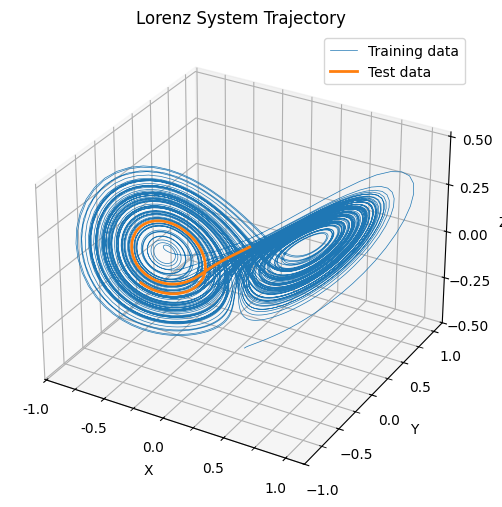

In [3]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(dataset['train'][:,0], dataset['train'][:,1], dataset['train'][:,2], lw=.5, label='Training data')
ax.plot(dataset['test'][:,0], dataset['test'][:,1], dataset['test'][:,2], lw=2, label='Test data')
ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X")
ax.set_xticks(np.linspace(-1,1,5),)
ax.set_xticklabels(np.linspace(-1,1,5))
ax.set_ylabel("Y")
ax.set_yticks(np.linspace(-1,1,5))
ax.set_zlabel("Z")
ax.set_zticks(np.linspace(-.5,.5,5))

spacing = 0.25
minorLocator = MultipleLocator(spacing)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which = 'minor')

plt.legend()
plt.show()

Set parameters.

In [4]:
flag_params = {}
flag_params["batch_size"] = 16
flag_params["koopman_kernel_length_scale"] = 0.24
flag_params["input_length"] = 12
flag_params["train_output_length"] = 1
flag_params["koopman_kernel_num_centers"] = 500
flag_params["context_mode"] = "last_context"
flag_params["mask_koopman_operator"] = False
flag_params["mask_version"] = 1
flag_params["use_nystroem_context_window"] = False

flag_params["context_length"] = flag_params["input_length"] + flag_params["train_output_length"]

flag_params["learning_rate"] = 0.001
flag_params["decay_rate"] = 0.9


flag_params["num_epochs"] = 50

Define the model.

In [5]:
scaler = LinearScaler()
eval_metric = RMSE
model_name = "test_model"

rbf = RBFKernel(length_scale=flag_params["koopman_kernel_length_scale"])
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=flag_params["input_length"],
    output_length=flag_params["train_output_length"],
    output_dim=1,
    num_nys_centers=flag_params["koopman_kernel_num_centers"],
    rng_seed=42,
    context_mode=flag_params["context_mode"],
    mask_koopman_operator=flag_params["mask_koopman_operator"],
    mask_version=flag_params["mask_version"],
    use_nystroem_context_window=flag_params["use_nystroem_context_window"],
)

Training and test sets and initialize Nystroem kernels.

In [6]:
tensor_context_inps_train, tensor_context_tgts_train = (
    standardized_batched_context_from_time_series_list(
        time_series_list_train,
        flag_params["batch_size"],
        scaler,
        context_length=flag_params["context_length"],
        time_lag=1,
        fit=True,
        input_length=flag_params["input_length"],
        output_length=flag_params["train_output_length"],
    )
)
tensor_context_inps_valid, tensor_context_tgts_valid = (
    standardized_batched_context_from_time_series_list(
        time_series_list_valid,
        flag_params["batch_size"],
        scaler,
        context_length=flag_params["context_length"],
        time_lag=1,
        fit=False,
        input_length=flag_params["input_length"],
        output_length=flag_params["train_output_length"],
    )
)
tensor_context_inps_test, tensor_context_tgts_test = (
    standardized_batched_context_from_time_series_list(
        time_series_list_test,
        flag_params["batch_size"],
        scaler,
        context_length=flag_params["context_length"],
        time_lag=1,
        fit=False,
        input_length=flag_params["input_length"],
        output_length=flag_params["train_output_length"],
    )
)

print(tensor_context_inps_train.shape)

koopkernelmodel._initialize_nystrom_data(
    tensor_context_inps_train=tensor_context_inps_train,
    tensor_context_tgts_train=tensor_context_tgts_train,
)

torch.Size([16, 624, 12, 3])


Define optimizer, loss function and scheduler.

In [7]:
optimizer = torch.optim.Adam(koopkernelmodel.parameters(), lr=flag_params["learning_rate"])
loss_koopkernel = KoopKernelLoss(koopkernelmodel.nystrom_data_Y, koopkernelmodel._kernel)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=flag_params["decay_rate"]
)  # stepwise learning rate decay

Training (around 1 mins for 50 epochs)

In [8]:
all_train_rmses, all_eval_rmses = [], []
best_eval_rmse = 1e6

training_time_start = time.time()
for epoch_index, epoch in enumerate(range(flag_params["num_epochs"])):
    start_time = time.time()

    train_rmse = train_one_epoch(
        koopkernelmodel,
        optimizer,
        loss_koopkernel,
        tensor_context_inps_train,
        tensor_context_tgts_train,
    )
    eval_rmse, _, _ = eval_one_epoch(
        koopkernelmodel,
        loss_koopkernel,
        tensor_context_inps_valid,
        tensor_context_tgts_valid,
    )

    print("eval comparison", eval_rmse, best_eval_rmse)
    if eval_rmse < best_eval_rmse:
        best_eval_rmse = eval_rmse
        best_model = koopkernelmodel

    all_train_rmses.append(train_rmse)
    all_eval_rmses.append(eval_rmse)

    if np.isnan(train_rmse) or np.isnan(eval_rmse):
        raise ValueError("The model generate NaN values")

    # Save test scores.
    _, test_preds, test_tgts = eval_one_epoch(
        best_model,
        loss_koopkernel,
        tensor_context_inps_test,
        tensor_context_tgts_test,
    )

    scheduler.step()

training_runtime = time.time() - training_time_start

eval comparison 0.5346995361156092 1000000.0
eval comparison 0.10454721338527553 0.5346995361156092
eval comparison 0.040335988087443174 0.10454721338527553
eval comparison 0.6079789160656188 0.040335988087443174
eval comparison 0.05507640111743734 0.040335988087443174
eval comparison 0.07601051918417281 0.040335988087443174
eval comparison 0.5083634020812046 0.040335988087443174
eval comparison 0.07509757007080063 0.040335988087443174
eval comparison 0.026425345273984182 0.040335988087443174
eval comparison 0.05204701062548946 0.026425345273984182
eval comparison 0.130307067140806 0.026425345273984182
eval comparison 0.052818548962085446 0.026425345273984182
eval comparison 0.11956120496395176 0.026425345273984182
eval comparison 0.09808165692599248 0.026425345273984182
eval comparison 0.18253902620481527 0.026425345273984182
eval comparison 0.1470206985001107 0.026425345273984182
eval comparison 0.035428022473776 0.026425345273984182
eval comparison 0.05677574988672818 0.026425345273

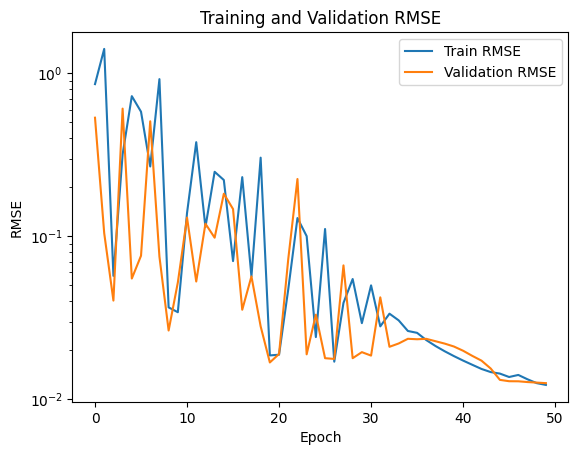

In [10]:
fig, ax = plt.subplots()

ax.plot(range(flag_params["num_epochs"]), all_train_rmses, label="Train RMSE")
ax.plot(range(flag_params["num_epochs"]), all_eval_rmses, label="Validation RMSE")

ax.set_title("Training and Validation RMSE")
ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
ax.legend()
ax.set_yscale("log")

## Import trained model for plotting

Training of the model for different architectures and training settings is done in `train_models/train_koopkernel_sequence.py`. We plot the results below.

In [1]:
import os
import random
from matplotlib import pyplot as plt
from itertools import product

import numpy as np
import torch

from kkseq.koopkernel_sequencer_utils import get_model_name

Setting parameters

In [2]:
time_lag = 1


# Set training settings
training_settings = {
    "koopman_kernel_length_scale": [0.16, 0.18, 0.20, 0.22, 0.24],
    "koopman_kernel_num_centers": [500],
    "context_mode": ["full_context", "last_context"],
    "mask_koopman_operator": [True, False],
    "mask_version": [1],
    "use_nystroem_context_window": [False, True],
    "output_length": [1],
}


flag_params = {}
flag_params["batch_size"] = 16
flag_params["input_length"] = 12
flag_params["learning_rate"] = 0.001
flag_params["decay_rate"] = 0.9


flag_params["num_epochs"] = 3
flag_params["seed"] = 24


random.seed(flag_params["seed"])  # python random generator
np.random.seed(flag_params["seed"])  # numpy random generator


current_file_dir_path = os.getcwd()


flag_params["dataset"] = "lorenz63"

In [3]:
res_dict = {}

model_str = "koopkernelseq"

flag_params["model"] = model_str

str_date_time = "2025-03-31-08-01-50"

results_dir = os.path.join(
    current_file_dir_path,
    "../model_training/training_results",
    "kkseq",
    flag_params["model"],
    str_date_time,
)

for (
    koopman_kernel_length_scale,
    koopman_kernel_num_centers,
    context_mode,
    mask_koopman_operator,
    mask_version,
    use_nystroem_context_window,
    output_length,
) in product(*training_settings.values()):
    if context_mode == "last_context":
        if mask_koopman_operator:
            continue

    flag_params["train_output_length"] = output_length
    flag_params["test_output_length"] = flag_params["train_output_length"]

    flag_params["koopman_kernel_length_scale"] = koopman_kernel_length_scale
    flag_params["koopman_kernel_num_centers"] = koopman_kernel_num_centers
    flag_params["context_mode"] = context_mode
    flag_params["mask_koopman_operator"] = mask_koopman_operator
    flag_params["mask_version"] = mask_version
    flag_params["use_nystroem_context_window"] = use_nystroem_context_window
    if flag_params["context_mode"] == "no_context":
        flag_params["input_length"] = (
            4  # small input_length for context_mode = no_context
        )
    else:
        flag_params["input_length"] = 12
    flag_params["context_length"] = (
        flag_params["input_length"] + flag_params["train_output_length"]
    )


    model_name = get_model_name(flag_params)

    res_dict[
        (
            koopman_kernel_length_scale,
            koopman_kernel_num_centers,
            context_mode,
            mask_koopman_operator,
            mask_version,
            use_nystroem_context_window,
            output_length,
        )
    ] = torch.load(
        os.path.join(results_dir, "test_" + model_name + ".pt"),
        weights_only=False,
    )

### Full parameter search

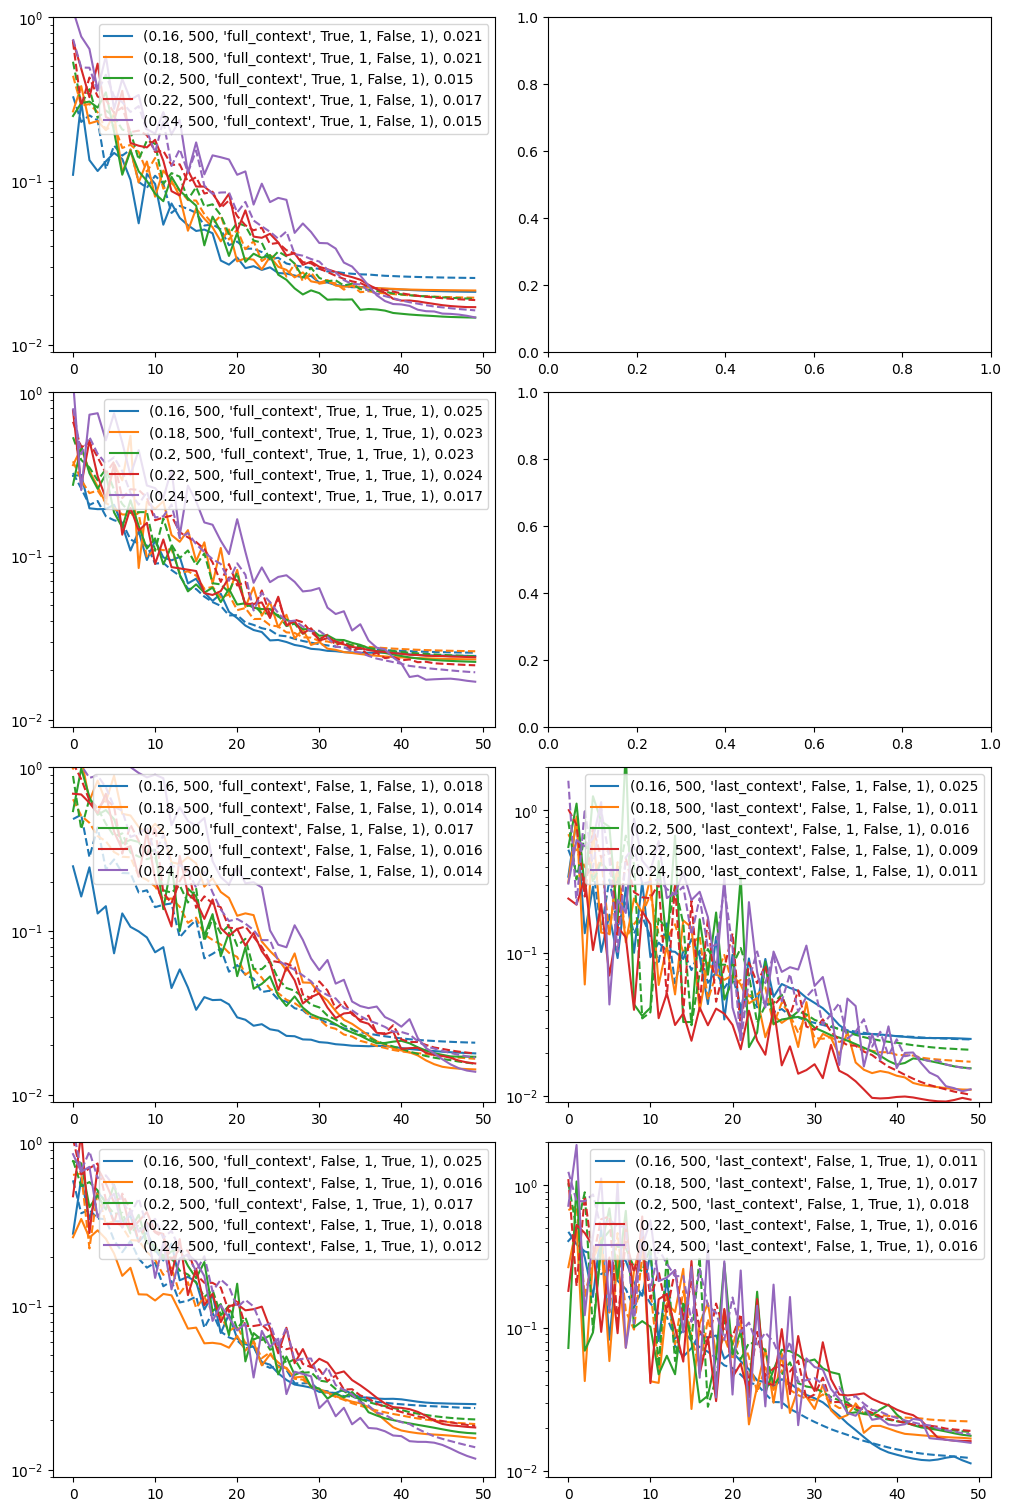

In [4]:
plot_settings = {
    "koopman_kernel_length_scale": [0.16, 0.18, 0.20, 0.22, 0.24],
    "koopman_kernel_num_centers": [500],
    "context_mode": ["full_context", "last_context"],
    "mask_koopman_operator": [True, False],
    "mask_version": [1],
    "use_nystroem_context_window": [False, True],
    "output_length": [1],
}

nrows = len(
    list(
        product(
            plot_settings["mask_koopman_operator"],
            plot_settings["use_nystroem_context_window"],
        )
    )
)

fig, ax = plt.subplots(nrows=nrows, ncols=2, layout="constrained")
fig.set_size_inches(10, 15)

koopman_kernel_num_centers = plot_settings["koopman_kernel_num_centers"][0]
mask_version = plot_settings["mask_version"][0]
output_length = plot_settings["output_length"][0]


for idx_row, (mask_koopman_operator, use_nystroem_context_window) in enumerate(
    product(
        plot_settings["mask_koopman_operator"],
        plot_settings["use_nystroem_context_window"],
    )
):
    for idx_kkls, koopman_kernel_length_scale in enumerate(
        plot_settings["koopman_kernel_length_scale"]
    ):
        context_mode = plot_settings["context_mode"][0]
        conf = (
            koopman_kernel_length_scale,
            koopman_kernel_num_centers,
            context_mode,
            mask_koopman_operator,
            mask_version,
            use_nystroem_context_window,
            output_length,
        )
        y = res_dict[conf]["eval_rmses"]
        ymin = np.min(y)
        x = range(len(y))
        ax[idx_row, 0].plot(
            x, y, color=f"C{idx_kkls}", label=str(conf) + f", {ymin:.3f}"
        )
        y = res_dict[conf]["train_rmses"]
        x = range(len(y))
        ax[idx_row, 0].plot(x, y, color=f"C{idx_kkls}", linestyle="dashed")

        if not mask_koopman_operator:
            context_mode = plot_settings["context_mode"][1]
            conf = (
                koopman_kernel_length_scale,
                koopman_kernel_num_centers,
                context_mode,
                mask_koopman_operator,
                mask_version,
                use_nystroem_context_window,
                output_length,
            )
            y = res_dict[conf]["eval_rmses"]
            ymin = np.min(y)
            x = range(len(y))
            ax[idx_row, 1].plot(
                x, y, color=f"C{idx_kkls}", label=str(conf) + f", {ymin:.3f}"
            )
            y = res_dict[conf]["train_rmses"]
            x = range(len(y))
            ax[idx_row, 1].plot(x, y, color=f"C{idx_kkls}", linestyle="dashed")

    ax[idx_row, 0].set_ylim(9e-3, 1e0)
    ax[idx_row, 0].set_yscale("log")
    ax[idx_row, 0].legend()

    if not mask_koopman_operator:
        ax[idx_row, 1].set_ylim(9e-3, 2e0)
        ax[idx_row, 1].set_yscale("log")
        ax[idx_row, 1].legend()


# fig.savefig("parameter_search_KoopKernelSequencer_lls.pdf")


### Make a nice plot

Generate Lorenz63 data.

In [5]:
from kooplearn.datasets import Lorenz63
from matplotlib.ticker import MultipleLocator

In [6]:
configs = {
    "train_samples": 10000,
    "valid_samples": 1000,
    "test_samples": 100,
}

raw_data = Lorenz63().sample(
    X0=np.ones(3),
    T=configs["train_samples"]
    + 1000
    + configs["valid_samples"]
    + 1000
    + configs["test_samples"],
)
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm
dataset = {
    "train": data[: configs["train_samples"] + 1],
    "valid": data[
        configs["train_samples"] + 1 + 1000 : configs["train_samples"]
        + 1
        + 1000
        + configs["valid_samples"]
        + 1
    ],
    "test": data[-configs["test_samples"] - 1 :],
}
time_series_list_train = [dataset["train"]]
time_series_list_valid = [dataset["valid"]]
time_series_list_test = [dataset["test"]]

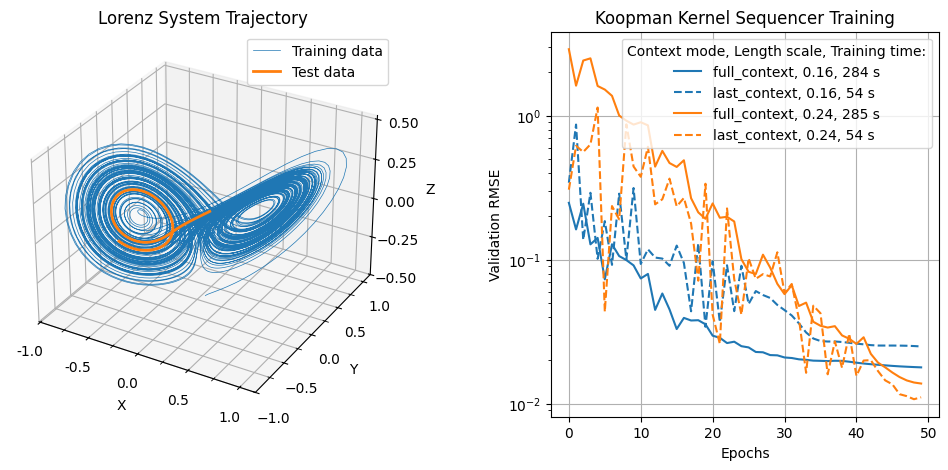

In [8]:
fig = plt.figure(figsize=(12,5))
# fig = plt.figure(figsize=(12,4), layout="constrained")

ax = fig.add_subplot(121, projection='3d')
ax.plot(dataset['train'][:,0], dataset['train'][:,1], dataset['train'][:,2], lw=.5, label='Training data')
ax.plot(dataset['test'][:,0], dataset['test'][:,1], dataset['test'][:,2], lw=2, label='Test data')
ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X")
ax.set_xticks(np.linspace(-1,1,5),)
ax.set_xticklabels(np.linspace(-1,1,5))
ax.set_ylabel("Y")
ax.set_yticks(np.linspace(-1,1,5))
ax.set_zlabel("Z")
ax.set_zticks(np.linspace(-.5,.5,5))

spacing = 0.25
minorLocator = MultipleLocator(spacing)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which = 'minor')

ax.legend()



#========================================
ax = fig.add_subplot(122)
plot_settings = {
    "koopman_kernel_length_scale": [0.16, 0.24],
    "koopman_kernel_num_centers": [500],
    "context_mode": ["full_context", "last_context"],
    "mask_koopman_operator": [False],
    "mask_version": [1],
    # "mask_version": [0, 1],
    "use_nystroem_context_window": [False],
    "output_length": [1],
}


koopman_kernel_num_centers = plot_settings["koopman_kernel_num_centers"][0]
mask_version = plot_settings["mask_version"][0]
output_length = plot_settings["output_length"][0]
mask_koopman_operator = plot_settings["mask_koopman_operator"][0]
use_nystroem_context_window = plot_settings["use_nystroem_context_window"][0]


for idx_ls, koopman_kernel_length_scale in enumerate(plot_settings["koopman_kernel_length_scale"]):

    context_mode = plot_settings["context_mode"][0]
    conf = (
        koopman_kernel_length_scale,
        koopman_kernel_num_centers,
        context_mode,
        mask_koopman_operator,
        mask_version,
        use_nystroem_context_window,
        output_length,
    )
    y = res_dict[conf]["eval_rmses"]
    ymin = np.min(y)
    x = range(len(y))
    ax.plot(
        x,
        y,
        color=f"C{idx_ls}",
        label=f"{context_mode}, {koopman_kernel_length_scale}, {res_dict[conf]['training_runtime']:.0f} s",
    )


    context_mode = plot_settings["context_mode"][1]
    conf = (
        koopman_kernel_length_scale,
        koopman_kernel_num_centers,
        context_mode,
        mask_koopman_operator,
        mask_version,
        use_nystroem_context_window,
        output_length,
    )
    y = res_dict[conf]["eval_rmses"]
    ymin = np.min(y)
    x = range(len(y))
    ax.plot(
        x,
        y,
        color=f"C{idx_ls}",
        linestyle="dashed",
        label=f"{context_mode}, {koopman_kernel_length_scale}, {res_dict[conf]['training_runtime']:.0f} s",
    )


ax.set_xlabel("Epochs")
ax.set_ylabel("Validation RMSE")
# ax.set_ylim(3e-3, 5e0)
ax.set_yscale("log")
ax.grid()
ax.legend(title="Context mode, Length scale, Training time:")
ax.set_title("Koopman Kernel Sequencer Training")


plt.subplots_adjust(wspace=0.4,hspace=0.5)
# fig.savefig("../plots/Lorenz_attractor_kkseq_training.png")